In [1]:
#| echo: false
#| include: false


#Load Package
# ================
# Basic Utilities
# ================
import os
import pandas as pd
from pathlib import Path
import numpy as np

# ================
# Geospatial Data
# ================
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.ops import unary_union

# ================
# Raster Handling
# ================
import rasterio
from rasterio.plot import show
from rasterio.mask import mask 
from rasterio import features
from rasterio.sample import sample_gen

# ================
# Visualization
# ================
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import contextily as ctx

# ================
# Machine Learning
# ================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# ================
# Spatial Analysis Utils
# ================
from scipy.ndimage import distance_transform_edt


data_dir = Path("data")
os.listdir(data_dir)


['.ipynb_checkpoints',
 'difference_map.tif',
 'dist_road.tif',
 'dist_village.tif',
 'dist_water.tif',
 'EFCOM_approx.cpg',
 'EFCOM_approx.dbf',
 'EFCOM_approx.prj',
 'EFCOM_approx.shp',
 'EFCOM_approx.shx',
 'gadm41_THA_0.cpg',
 'gadm41_THA_0.dbf',
 'gadm41_THA_0.prj',
 'gadm41_THA_0.shp',
 'gadm41_THA_0.shx',
 'LandCover_EFCOM_to_NDVI.tif',
 'major_roads.geojson',
 'NDVI_EFCOM_32647.tif',
 'NDVI_EFCOM_4326.tif',
 'NDVI_Thailand_2024_fixed.tif',
 'occurrence.geojson',
 'studyregion.geojson',
 'suitability_human.tif',
 'suitability_natural.tif',
 'village_polygon.geojson',
 'water_efcom.geojson',
 'WorldCover_EFCOM_2021.tif']

In [2]:
#| echo: false
#| include: false


#Check CRS

study_region_path = Path(data_dir) / "studyregion.geojson"
if study_region_path.exists():
    region = gpd.read_file(study_region_path)
else:
    region = gpd.read_file(Path(data_dir) / "EFCOM_approx.shp")

print("Study region CRS:", region.crs)

roads = gpd.read_file(Path(data_dir) / "major_roads.geojson")
villages = gpd.read_file(Path(data_dir) / "village_polygon.geojson")
water = gpd.read_file(Path(data_dir) / "water_efcom.geojson")
occ = gpd.read_file(Path(data_dir) / "occurrence.geojson")

print("Roads CRS:", roads.crs)
print("Villages CRS:", villages.crs)
print("Water CRS:", water.crs)
print("Occurrence CRS:", occ.crs)


Study region CRS: EPSG:4326


C:\Users\m1870\.conda\envs\musa\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 25830291 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(
C:\Users\m1870\.conda\envs\musa\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 477127100 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


Roads CRS: EPSG:4326
Villages CRS: EPSG:4326
Water CRS: EPSG:4326
Occurrence CRS: EPSG:4326


In [3]:
#| echo: false
#| include: false

#Trim Elephant Data To Study Region

region_union = region.unary_union
occ_in_region = occ[occ.within(region_union)].copy()

print("All elephant points:", len(occ))
print("Elephant points inside region:", len(occ_in_region))


All elephant points: 577
Elephant points inside region: 260


C:\Users\m1870\AppData\Local\Temp\ipykernel_14428\857401672.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  region_union = region.unary_union


In [4]:
#| echo: false
#| include: false


ndvi_path = Path(data_dir) / "NDVI_Thailand_2024_fixed.tif"
ndvi_src = rasterio.open(ndvi_path)

print("NDVI CRS:", ndvi_src.crs)
print("NDVI bounds:", ndvi_src.bounds)
print("NDVI resolution:", ndvi_src.transform.a, ndvi_src.transform.e)

ndvi = ndvi_src.read(1)
ndvi = ndvi.astype("float32")
ndvi[ndvi <= -9999] = np.nan  

print("NDVI min/max (ignoring NaN):", np.nanmin(ndvi), np.nanmax(ndvi))


NDVI CRS: PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NDVI bounds: BoundingBox(left=704880.0, bottom=1343880.0, right=878400.0, top=1638090.0)
NDVI resolution: 30.0 -30.0
NDVI min/max (ignoring NaN): -0.38841534 0.71352226


In [5]:
#| echo: false
#| include: false


region_ndvi = region.to_crs(ndvi_src.crs)
geoms = [geom for geom in region_ndvi.geometry]

ndvi_clip, ndvi_clip_transform = mask(ndvi_src, geoms, crop=True)
ndvi_clip = ndvi_clip[0] 

print("Clipped NDVI shape:", ndvi_clip.shape)
print("Clipped NDVI min/max:", ndvi_clip.min(), ndvi_clip.max())


Clipped NDVI shape: (8924, 5435)
Clipped NDVI min/max: -0.36105967 0.71352226


In [6]:
#| echo: false
#| include: false

# 先确保大象点的 CRS 和 NDVI 一致（NDVI 是 4326）
occ_ndvi = occ_in_region.to_crs(ndvi_src.crs)

# 提取点坐标
coords = [(x,y) for x, y in zip(occ_ndvi.geometry.x, occ_ndvi.geometry.y)]

# 在 NDVI 栅格上采样
ndvi_at_elephants = list(ndvi_src.sample(coords))
ndvi_at_elephants = np.array(ndvi_at_elephants).flatten().astype("float32")

# 去掉可能的 NaN（落在 NoData 区域的点）
ndvi_at_elephants = ndvi_at_elephants[~np.isnan(ndvi_at_elephants)]

print("Elephant NDVI count:", len(ndvi_at_elephants))
print("Elephant NDVI min/max:", ndvi_at_elephants.min(), ndvi_at_elephants.max())
print("Elephant NDVI mean:", ndvi_at_elephants.mean())


Elephant NDVI count: 260
Elephant NDVI min/max: 0.02474089 0.59356636
Elephant NDVI mean: 0.4537316


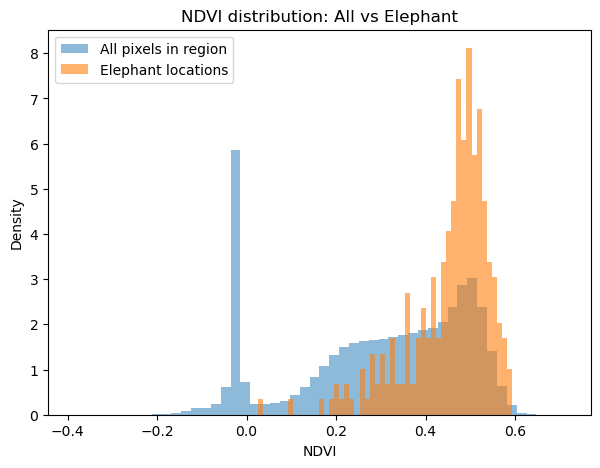

In [7]:
#| echo: false
#| include: false


# 全区域 NDVI 展平 & 去 NaN
ndvi_all = ndvi.flatten()
ndvi_all = ndvi_all[~np.isnan(ndvi_all)]

plt.figure(figsize=(7,5))

plt.hist(ndvi_all, bins=50, alpha=0.5, density=True, label="All pixels in region")
plt.hist(ndvi_at_elephants, bins=50, alpha=0.6, density=True, label="Elephant locations")

plt.xlabel("NDVI")
plt.ylabel("Density")
plt.title("NDVI distribution: All vs Elephant")
plt.legend()
plt.show()



In [8]:
#| echo: false
#| include: false

lc_path = data_dir / "WorldCover_EFCOM_2021.tif"
lc_src = rasterio.open(lc_path)

print("LandCover CRS:", lc_src.crs)
print("LandCover bounds:", lc_src.bounds)
print("LandCover resolution:", lc_src.transform.a, lc_src.transform.e)

lc = lc_src.read(1)
print("Unique landcover classes in full raster:", np.unique(lc))


LandCover CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
LandCover bounds: BoundingBox(left=100.99983318176811, bottom=12.29973287016449, right=102.60009202889863, top=14.700121140860263)
LandCover resolution: 0.00026949458523585647 -0.00026949458523585647
Unique landcover classes in full raster: [ 0 10 20 30 40 50 60 80 90 95]


In [9]:
#| echo: false
#| include: false


region_lc = region.to_crs(lc_src.crs)
geoms_lc = [geom for geom in region_lc.geometry]

lc_clip, lc_clip_transform = rasterio.mask.mask(lc_src, geoms_lc, crop=True)
lc_clip = lc_clip[0]

print("Clipped LC shape:", lc_clip.shape)
print("Unique classes in clipped LC:", np.unique(lc_clip))


Clipped LC shape: (8907, 5938)
Unique classes in clipped LC: [ 0 10 20 30 40 50 60 80 90 95]


## Data Preparation: Environmental Covariates  
To model elephant habitat suitability within the Eastern Forest Complex (EFCOM), we compiled a set of environmental predictors representing both natural habitat conditions and human-influenced landscape features. These covariates capture vegetation quality, land cover patterns, and the proximity of landscape elements that strongly shape elephant movement and space use.

The following subsections describe each covariate and present summary visualizations.


### Land Cover Composition

The land cover map below shows the spatial distribution of major habitat types within the Eastern Forest Complex (EFCOM). Evergreen forest (deep green) dominates the interior of the protected area, forming the core ecological zone where most elephant activity is expected to occur. Surrounding the protected forest, large patches of cropland and plantation (yellow and light green) create a fragmented transition zone between forest and human-modified landscapes. 

Urban and built-up areas (red) appear in scattered clusters, mostly along road networks and settlement centers, while water bodies (blue) are concentrated in the southern part of the region. This mosaic of forest, agriculture, villages, and infrastructure reflects the complex ecological and social environment in which elephants move. 


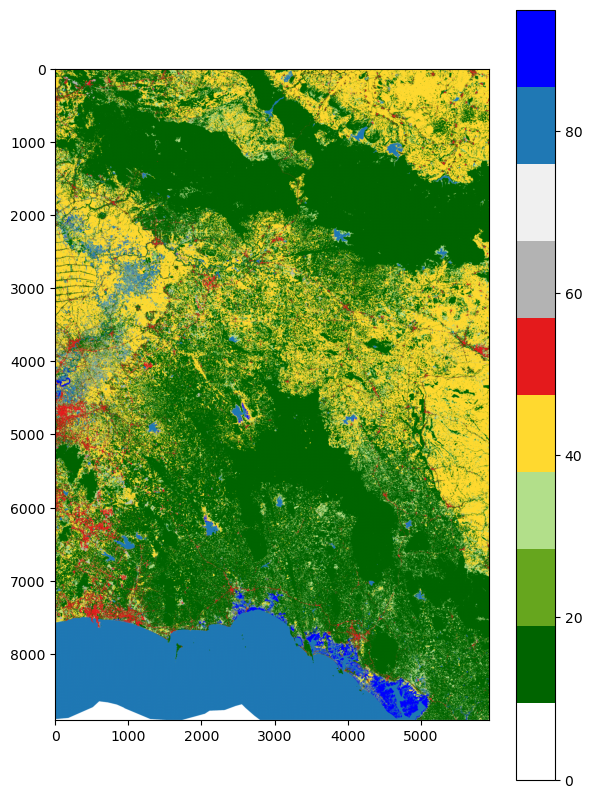

In [10]:
#| code-fold: true
#| fig-cap: "Study Region: Landcover"

class_colors = [
    "#ffffff",  # 0  No data
    "#006400",  # 10 Tree - dark green
    "#66a61e",  # 20 Shrub - olive green
    "#b2df8a",  # 30 Grass - light green
    "#ffd92f",  # 40 Cropland - light yellow
    "#e41a1c",  # 50 Built-up - red
    "#b3b3b3",  # 60 Bare - grey
    "#f0f0f0",  # 80 Snow/Ice - white
    "#1f78b4",  # 90 Wetlands - teal blue
    "#0000ff",  # 95 Water - blue
]


cmap = ListedColormap(class_colors)

plt.figure(figsize=(7, 10))
plt.imshow(lc_clip, cmap=cmap)
plt.colorbar()
plt.show()


The land cover distribution shows that tree cover dominates the study region, accounting for over half of all pixels and forming the ecological core of the Eastern Forest Complex. Cropland makes up about 22% of the area, creating a wide agricultural belt around the forest and representing the primary zone of human–elephant interaction and conflict. 

Grassland, built-up areas, and bare land occur in smaller patches but play an important role along forest edges and settlement clusters. Water bodies and wetlands represent less than 1% of the region but provide essential resources for elephant movement. Snow/Ice appears due to classification artifacts in the satellite imagery and does not represent actual environmental conditions in Thailand.

In [11]:
#| code-fold: true
#| fig-cap: "Landcover types overview"

class_meaning = {
    0:  "No data",
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/Sparse vegetation",
    80: "Snow/Ice",
    90: "Wetlands",
    95: "Water"
}

unique, counts = np.unique(lc_clip, return_counts=True)

df_lc = pd.DataFrame({
    "ClassValue": unique,
    "Meaning": [class_meaning.get(v, "Unknown") for v in unique],
    "Count": counts
})

df_lc["Percentage"] = (df_lc["Count"] / df_lc["Count"].sum() * 100).round(2)

df_lc


,ClassValue,Meaning,Count,Percentage
0,0,No data,292666,0.55
1,10,Tree cover,28505457,53.90
2,20,Shrubland,3019,0.01
3,30,Grassland,4133549,7.82
4,40,Cropland,11810797,22.33
5,50,Built-up,1499059,2.83
6,60,Bare/Sparse vegetation,292243,0.55
7,80,Snow/Ice,5949448,11.25
8,90,Wetlands,91315,0.17
9,95,Water,312213,0.59


In [12]:
#| echo: false
#| include: false

# 输入：occurrence_in_region（象点）
ele_df = occ_in_region.copy()

coords = [(x,y) for x,y in zip(ele_df.geometry.x, ele_df.geometry.y)]

with rasterio.open(lc_path) as src:
    ele_df["landcover"] = [v[0] for v in src.sample(coords)]

ele_df.head()


,gbifID,accessRights,bibliographicCitation,language,license,modified,publisher,references,rightsHolder,type,...,level0Name,level1Gid,level1Name,level2Gid,level2Name,level3Gid,level3Name,iucnRedListCategory,geometry,landcover
1,5892584119,None,None,None,CC_BY_NC_4_0,2025-11-06 13:07:19+00:00,None,https://www.inaturalist.org/observations/32514...,CaracalShan,None,...,Thailand,THA.60_1,Saraburi,THA.60.5_1,Muak Lek,THA.60.5.3_1,Mittraphap,EN,POINT (101.20073 14.44923),10
4,5889647550,None,None,None,CC_BY_NC_4_0,2025-10-24 06:51:04+00:00,None,https://www.inaturalist.org/observations/32270...,balayska,None,...,Thailand,THA.29_1,Nakhon Ratchasima,THA.29.25_1,Pak Chong,THA.29.25.5_1,Mu Si,EN,POINT (101.45096 14.51415),30
6,5889402805,None,None,None,CC_BY_NC_4_0,2025-11-04 20:25:29+00:00,None,https://www.inaturalist.org/observations/32473...,Toby Austin,None,...,Thailand,THA.29_1,Nakhon Ratchasima,THA.29.25_1,Pak Chong,THA.29.25.1_1,Chanthuek,EN,POINT (101.34412 14.58563),10
10,5838232009,None,None,None,CC_BY_NC_4_0,2025-10-03 20:16:07+00:00,None,https://www.inaturalist.org/observations/31770...,Sila Viriyautsahakul,None,...,Thailand,THA.26_1,Nakhon Nayok,THA.26.2_1,Muang Nakhon Nayok,THA.26.2.1_1,None,EN,POINT (101.25046 14.45802),10
12,5838086501,None,None,None,CC_BY_NC_4_0,2025-09-27 03:09:24+00:00,None,https://www.inaturalist.org/observations/31422...,julien CLAUDE,None,...,Thailand,THA.29_1,Nakhon Ratchasima,THA.29.25_1,Pak Chong,THA.29.25.4_1,Klang Dong,EN,POINT (101.2909 14.59323),10


In [13]:
#| echo: false
#| include: false

class_colors = {
    0:  "#ffffff",  # No data
    10: "#006400",  # Tree
    20: "#66a61e",  # Shrub
    30: "#b2df8a",  # Grass
    40: "#ffd92f",  # Cropland
    50: "#e41a1c",  # Built-up
    60: "#b3b3b3",  # Bare
    80: "#f0f0f0",  # Snow/Ice
    90: "#1f78b4",  # Wetlands
    95: "#0000ff",  # Water
}


To understand which environments elephants actually use within EFCOM, we extracted the land cover value at each occurrence point and calculated its percentage distribution. The bar chart below summarizes these results.

The pattern aligns closely with ecological expectations:  
- **Tree cover dominates (53.9%)**, confirming that forests remain the core habitat for wild elephants.  
- **Cropland (22.3%)** is the second-largest category, reflecting how elephants frequently travel through or feed near agricultural fields—one of the main drivers of human–elephant conflict.  
- Smaller proportions of grassland and snow/ice suggest occasional movement through mixed or transitional landscapes.  
- Built-up and water areas account for less than 3%, indicating limited use of heavily disturbed zones.

Overall, this distribution supports the idea that elephants inhabit predominantly forested areas but regularly approach human-modified land uses.

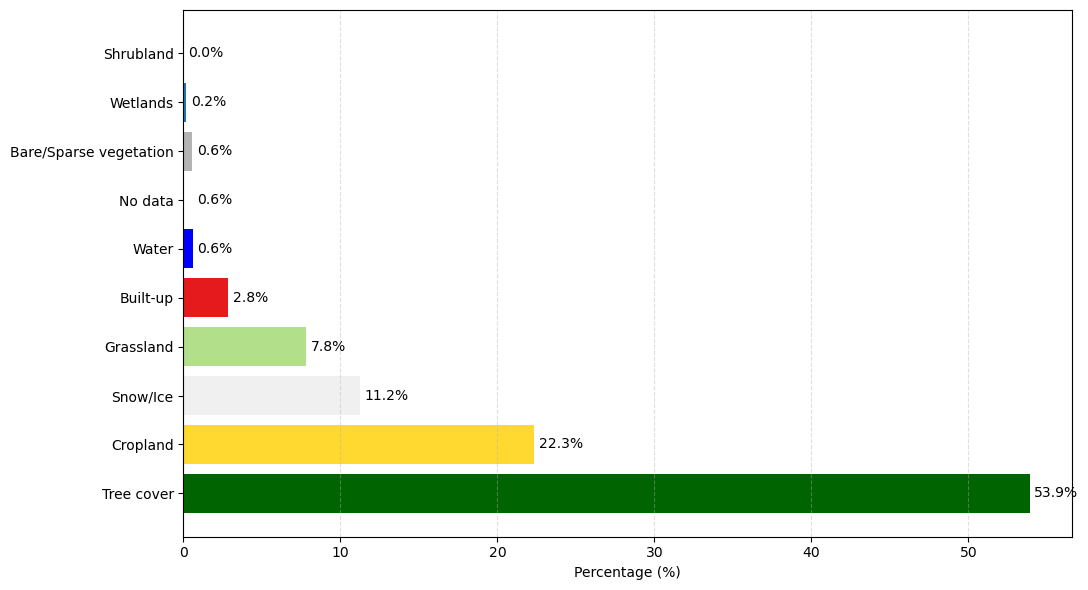

In [14]:
#| code-fold: true
#| fig-cap: "LandCover Types of Elephant Occurrence"

# Sort dataframe by % (largest to smallest)
df_plot = df_lc.sort_values("Percentage", ascending=False).copy()

# Map colors
df_plot["Color"] = df_plot["ClassValue"].map(class_colors)

# Plot
plt.figure(figsize=(11, 6))
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.barh(df_plot["Meaning"], df_plot["Percentage"], color=df_plot["Color"])
plt.xlabel("Percentage (%)")

# Add % text to bars
for i, v in enumerate(df_plot["Percentage"]):
    plt.text(v + 0.3, i, f"{v:.1f}%", va="center")

plt.tight_layout()
plt.show()



In [15]:
#| echo: false
#| include: false

efcom = gpd.read_file(
    r"data/studyregion.geojson"
)
efcom = efcom.to_crs(epsg=4326)


# 2. 随机点生成函数
def generate_random_points(polygon, n_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    count = 0
    
    while count < n_points:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        p = Point(x, y)
        if polygon.contains(p):
            points.append(p)
            count += 1
    return points

# 3. 生成 4000 个背景点
background_pts = generate_random_points(efcom.geometry.iloc[0], 4000)

background_gdf = gpd.GeoDataFrame(geometry=background_pts, crs="EPSG:4326")
background_gdf.to_file("background_points.geojson", driver="GeoJSON")


In [16]:
#| echo: false
#| include: false

ndvi_src = rasterio.open("data/NDVI_EFCOM_4326.tif")
lc_src   = rasterio.open("data/WorldCover_EFCOM_2021.tif")

def extract_raster_values(gdf, raster_src, colname):
    coords = [(x,y) for x,y in zip(gdf.geometry.x, gdf.geometry.y)]
    values = [val[0] for val in raster_src.sample(coords)]
    gdf[colname] = values
    return gdf

# Presence points
occ = extract_raster_values(occ_in_region, ndvi_src, "NDVI")
occ = extract_raster_values(occ, lc_src, "LC")

# Background points
bg  = extract_raster_values(background_gdf, ndvi_src, "NDVI")
bg  = extract_raster_values(bg, lc_src, "LC")


In [17]:
#| echo: false
#| include: false

def compute_distance(gdf, features_gdf, colname):
    """给每个点算到某类要素的最短距离"""
    union_geom = unary_union(features_gdf.geometry)
    gdf[colname] = gdf.geometry.apply(lambda x: x.distance(union_geom))
    return gdf

# 1. 先对 presence/background 都做距离特征
occ = compute_distance(occ, water,    "dist_water")
occ = compute_distance(occ, roads,    "dist_road")
occ = compute_distance(occ, villages, "dist_village")

bg  = compute_distance(bg, water,    "dist_water")
bg  = compute_distance(bg, roads,    "dist_road")
bg  = compute_distance(bg, villages, "dist_village")


In [18]:
#| echo: false
#| include: false

# 打标签
occ["presence"] = 1
bg["presence"]  = 0

cols_keep = ["NDVI", "LC", "dist_water", "dist_road", "dist_village", "presence"]

df = pd.concat([occ[cols_keep], bg[cols_keep]], ignore_index=True)

df["LC"] = df["LC"].astype("int32")

# 简单检查一下
print(df.head())
print(df["presence"].value_counts())


       NDVI  LC  dist_water  dist_road  dist_village  presence
0  0.454901  10    0.041045   0.104217      0.023324         1
1  0.261992  30    0.002616   0.132970      0.003885         1
2  0.333858  10    0.021377   0.042900      0.005348         1
3  0.508838  10    0.083699   0.154307      0.059516         1
4  0.525954  10    0.028356   0.028713      0.019645         1
presence
0    4000
1     260
Name: count, dtype: int64


### NDVI

We assembled NDVI data covering the entire study area to represent vegetation conditions. NDVI provides a direct indication of vegetation health and habitat quality and was incorporated as a key environmental variable to help the model characterize natural resource availability across the landscape.

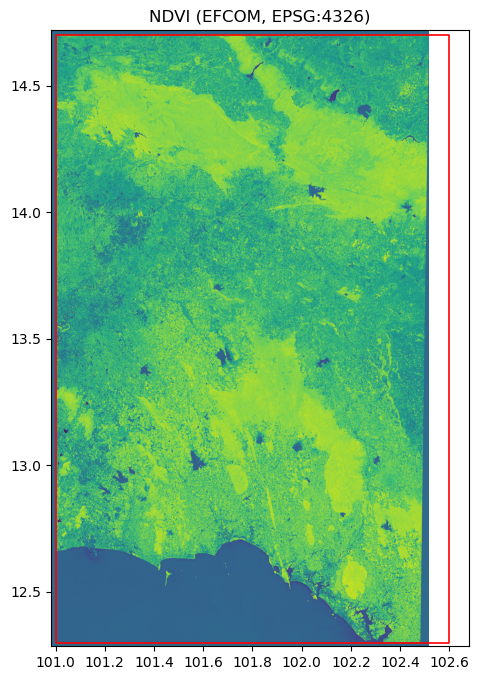

In [19]:
#| code-fold: true
#| fig-cap: "NDVI map"

ndvi_4326_path = data_dir / "NDVI_EFCOM_4326.tif"
ndvi_efcom_src = rasterio.open(ndvi_4326_path)
ndvi_efcom = ndvi_efcom_src.read(1)

fig, ax = plt.subplots(figsize=(6, 8))

show(ndvi_efcom, transform=ndvi_efcom_src.transform, ax=ax, cmap="viridis")
region.boundary.plot(ax=ax, edgecolor="red", linewidth=1.2)

ax.set_title("NDVI (EFCOM, EPSG:4326)")
plt.show()

### Roads, Water and Villages
We collected spatial layers representing major roads, village built-up areas, and water bodies across the study region. Among these, water features represent natural landscape elements, while roads and villages are human-made. To translate these features into variables the model could use, we calculated the shortest distance from each elephant occurrence point to each of these elements. These distance-based measurements allowed us to capture how proximity to natural and anthropogenic features influences elephant movement in a quantifiable way.

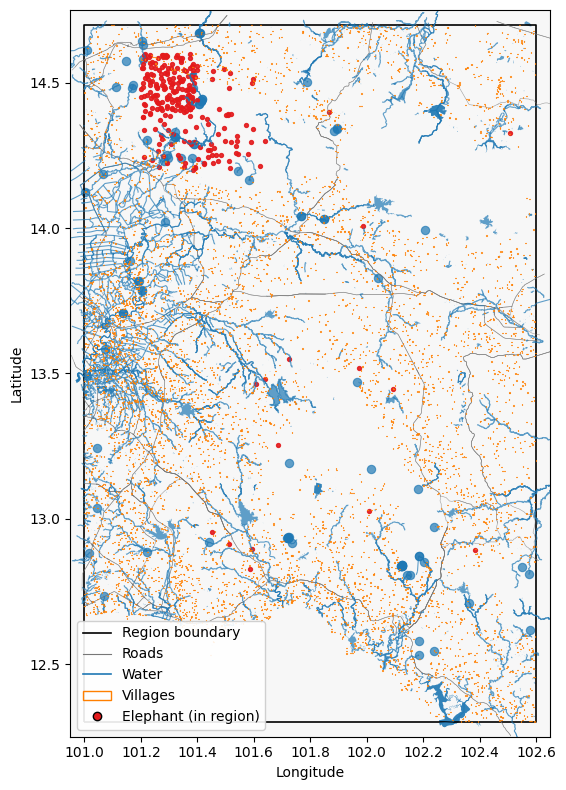

In [20]:
#| code-fold: true
#| fig-cap: "Study Region: Eastern Forest Complex and surrounding human features."

#Study Region Overview

minx, miny, maxx, maxy = region.total_bounds

fig, ax = plt.subplots(figsize=(6, 8))

# 1. Region Boundary
region.boundary.plot(
    ax=ax,
    edgecolor="black",
    linewidth=1.2
)

# 2. Roads
roads.plot(
    ax=ax,
    linewidth=0.4,
    color="#777777",
    alpha=0.7
)

# 3. Water
water.plot(
    ax=ax,
    linewidth=0.8,
    color="#1f78b4",
    alpha=0.7
)

# 4. Villages Boundary
villages.boundary.plot(
    ax=ax,
    linewidth=0.8,
    edgecolor="#ff7f00",
    alpha=0.8
)

# 5. Occurances
occ_in_region.plot(
    ax=ax,
    markersize=8,
    color="#e31a1c",
    alpha=0.9
)

ax.set_xlim(minx - 0.05, maxx + 0.05)
ax.set_ylim(miny - 0.05, maxy + 0.05)


ax.set_facecolor("#f7f7f7")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

legend_elements = [
    Line2D([0], [0], color="black", lw=1.2, label="Region boundary"),
    Line2D([0], [0], color="#777777", lw=0.8, label="Roads"),
    Line2D([0], [0], color="#1f78b4", lw=1.2, label="Water"),
    Patch(facecolor="none", edgecolor="#ff7f00", label="Villages"),
    Line2D([0], [0], marker="o", color="none",
           markerfacecolor="#e31a1c", markersize=6,
           label="Elephant (in region)")
]

ax.legend(handles=legend_elements, loc="lower left", frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()

### Correlation Between Features

The correlation matrix shows that most predictors are not strongly correlated, supporting their joint use in the Random Forest model. NDVI is moderately negatively correlated with distance to water and villages, reflecting how greener areas tend to occur closer to natural and human-modified edges. The strongest correlations appear among the human-related variables: distance to village and distance to water (0.89), and distance to road and distance to village (0.64), which is expected because settlements, roads, and water sources often cluster spatially. Despite these relationships, none of the correlations are high enough to cause concern for Random Forest, confirming that all variables can be meaningfully included without multicollinearity issues.

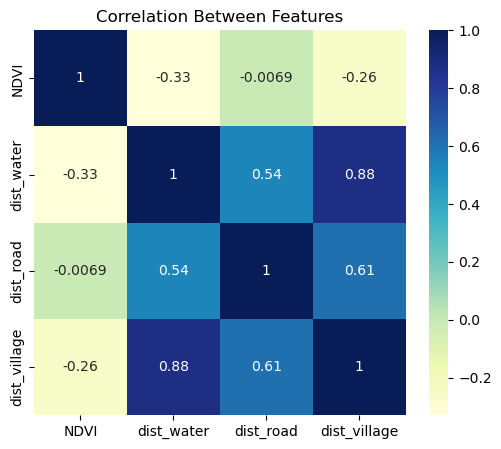

In [21]:
#| code-fold: true
#| fig-cap: "Correlation Between Features"

import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(df[["NDVI","dist_water","dist_road","dist_village"]].corr(),
            annot=True, cmap="YlGnBu")
plt.title("Correlation Between Features")
plt.show()
